In [0]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.tree import DecisionTreeClassifier

import numpy as np

sns.set(style="whitegrid")

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

# 0. Etapas da Sessão 01 e 02
Aqui nós colocamos todas as etapas das Sessões anterior uma única célula, para ver a explicação de cada etapa você pode olhar o notebook da Sessão 01 e da Sessão 02 em https://github.com/widsrecife/live-coding


In [0]:
# Ler dados de um CSV e coloca em um dataframe

df = pd.read_csv("https://raw.githubusercontent.com/widsrecife/dados/master/Sessao_1/Attribute%20DataSet.csv")

# Removendo linhas que não têm valor em Season

df = df.dropna(subset=["Season"])

# No pandas a gente pode selecionar uma coluna, aplicar uma função e salvar o resultado em uma nuva coluna;
#   para aplicar a função usamos a função apply()

def string_para_minusculo(valor):
    return str(valor).lower()

@np.vectorize
def vec_string_para_minusculo(valor):
    return str(valor).lower()

df["season_minusculo"] = df["Season"].apply(string_para_minusculo)

# Também podemos substituir determinados valores usando a função replace()

df["season_minusculo"] = df["season_minusculo"].replace({"autumn":"automn"})
df["SleeveLength"] = df["SleeveLength"].replace({"sleveless":"sleeveless","sleevless":"sleeveless","sleeevless":"sleeveless",
                                                 "cap-sleeves":"capsleeves","thressqatar":"threequarter",
                                                 "threequater":"threequarter","turndowncollor":np.nan,"half":np.nan,
                                                 "urndowncollor":np.nan, 
                                                 "butterfly":np.nan, 
                                                 "Petal":np.nan})
df = df.fillna("-1")

rotulos_string = df["season_minusculo"]

# O pandas tem várias formas de selecionar linhas e colundas ([], .loc, .iloc)
#   aqui vamos usar o [] (indexing operator) onde a gente passa uma lista com as colunas que queremos selecionar
colunas_utilizadas = ["Style","NeckLine","SleeveLength","Material","FabricType","Decoration"]

df_colunas_utilizadas = df[colunas_utilizadas]

# Nossa coluna de rótulos (labels em Inglês) tem Strings, mas precisamos que sejam números para usar os algoritmos
#   do scikit-learn
# Vamos converter as strings para números usando a classe LabelEncoder() do scikit-learn
#   Essa função transformar cada string em uma classe de 0 n_classes-1
#   Exemplo: ["vermelho","azul","azul"] se torna [0,1,1]

rotulos_encoder = preprocessing.LabelEncoder()

# Instanciamos a classe LabelEncoder() acima, mas para transformar os dados precisamos que a classe:
#   1. aprenda qual vai ser o número de cada string: método fit()
#   2. transforme os dados em números: método transform
rotulos_encoder.fit(rotulos_string)

rotulos = rotulos_encoder.transform(rotulos_string)

# O scikit-learn possui uma função chamada train_test_split() que divide um conjunto de dados em conjunto de treinamento
#   e conjunto de testes. Isso é importante porque sem o conjunto de testes a gente não vão poder avaliar se um modelo
#   apresenta bons resultados ou não
# Vamos usar o paramêtro stratify para que os dois conjuntos tenham a mesma proporção de classes

dados_treinamento, dados_teste, rotulos_treinamento, rotulos_teste = train_test_split(df_colunas_utilizadas,
                                                                                      rotulos,
                                                                                      stratify=rotulos,
                                                                                      test_size=0.33,
                                                                                      random_state=42)


# Strings para números com o OneHotEncoding
dados_treinamento_minusculo = dados_treinamento.apply(vec_string_para_minusculo,axis="index")

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

one_hot_encoder.fit(dados_treinamento_minusculo)

dados_treinamento_transformados_one_hot = one_hot_encoder.transform(dados_treinamento_minusculo)

FEATURE_NAMES = one_hot_encoder.get_feature_names()

# A gente pode escolher as features com mais poder preditivo
#   Vamos usar a classe SelectKBest do scikit-learn para fazer isso e a função chi2 para calcular os scores

seletor_de_features = SelectKBest(chi2, k=20)
dados_treinamento_features_selecionadas = seletor_de_features.fit_transform(dados_treinamento_transformados_one_hot, rotulos_treinamento)
features_selecionadas = FEATURE_NAMES[seletor_de_features.get_support()]

# Treinando o modelo
clf = DecisionTreeClassifier(max_depth=10, random_state=50)
clf = clf.fit(dados_treinamento_features_selecionadas, rotulos_treinamento)

## 1. Avaliando o modelo quanto ao viés e a variância
### 1.1 Como os dados são divididos?

In [0]:
# O StratifiedKFold particiona em k conjuntos com as mesmas porcentagens das classes
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(dados_treinamento_features_selecionadas,rotulos_treinamento)
for train_index, test_index in skf.split(dados_treinamento_features_selecionadas,rotulos_treinamento):
    display(pd.DataFrame(rotulos_treinamento).iloc[test_index][0].value_counts())

2    22
3    19
1    17
0     9
Name: 0, dtype: int64

2    22
3    19
1    17
0     9
Name: 0, dtype: int64

2    21
3    19
1    17
0    10
Name: 0, dtype: int64

2    21
3    20
1    16
0     9
Name: 0, dtype: int64

2    21
3    20
1    16
0     9
Name: 0, dtype: int64

### 1.2 Curva de treinamento

In [0]:
train_sizes = [50, 100, 150, 200, 266]
train_sizes, train_scores, test_scores = learning_curve(clf, dados_treinamento_features_selecionadas, rotulos_treinamento,
                                                        train_sizes=train_sizes,
                                                        scoring="balanced_accuracy",cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [0]:
# Temos 5 testes
print("shape:",train_scores.shape)
train_scores

shape: (5, 5)


array([[0.76706539, 0.74975198, 0.74975198, 0.74975198, 0.74975198],
       [0.59016495, 0.57127649, 0.68957281, 0.68957281, 0.68957281],
       [0.55135358, 0.61679451, 0.63469833, 0.53307909, 0.53307909],
       [0.53331939, 0.55151528, 0.5152803 , 0.58562594, 0.55130101],
       [0.53547024, 0.53324726, 0.58032584, 0.56063803, 0.56239882]])

In [0]:
# Podemos calcular a média para cada parâmetro
print("médias para score no conjunto de treinamento",train_scores_mean)
print("médias para score no conjunto de validação cruzada", test_scores_mean)

médias para score no conjunto de treinamento [0.75321467 0.64603198 0.57380092 0.54740838 0.55441604]
médias para score no conjunto de validação cruzada [0.30576653 0.32331335 0.33056689 0.37262358 0.34851404]


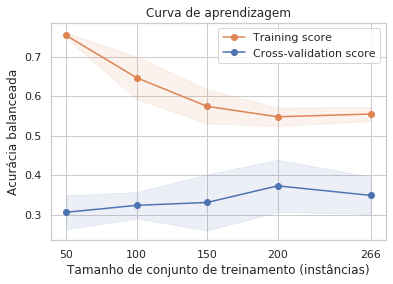

In [0]:
# Plot the scores
plt.figure()
plt.title('Curva de aprendizagem')
# Plot the standard deviations
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
 train_scores_mean + train_scores_std, alpha=0.1,
 color="C1")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
 test_scores_mean + test_scores_std, alpha=0.1, color="C0")

# Plot the means
plt.plot(train_sizes, train_scores_mean, 'o-', color="C1",
 label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="C0",
 label="Cross-validation score")

plt.xticks(train_sizes)
plt.xlabel('Tamanho de conjunto de treinamento (instâncias)')
plt.ylabel('Acurácia balanceada')
plt.legend(loc="best")
plt.show()

### 1.3 Curva da validação

In [0]:
param_range = [3,4,5,6,7,8,9,10]

train_scores, test_scores = validation_curve(clf, dados_treinamento_features_selecionadas, rotulos_treinamento,
                                             param_name='max_depth',
                                             param_range=param_range,
                                             cv=5,
                                             scoring="balanced_accuracy")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

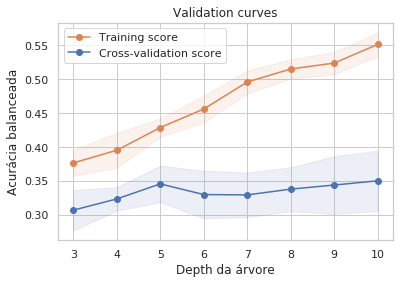

In [0]:
plt.figure()
plt.title('Validation curves')

# Plot the standard deviations
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="C1")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="C0")

# Plot the means
plt.plot(param_range, train_scores_mean, 'o-', color="C1",
         label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="C0",
         label="Cross-validation score")

plt.xticks(param_range)
plt.xlabel('Depth da árvore')
plt.ylabel('Acurácia balanceada')
plt.legend(loc="best")
plt.show()